# The Joe Lubin Attack

For the Joe Lubin attack, 

## Examples

In our cadCAD model simulation results, we will illustrate the Trajectors, and Rectangles via simulation plots. Our cadCAD simulation has the folllowing file structure:

* numerical_integration.ipynb
* model
In the model folder there exist 5 files and a parts folder, the [config.py](model/config.py), [partial_state_update_block.py](model/partial_state_update_block.py), [run.py](model/run.py), and [state_variables.py](model/state_variables.py), and [sys_params.py](model/sys_params.py). The *config.py* contains the simulation configurations, aggregating the partial states, and the state variables. The *partial_state_update_block.p*y contains the partial state update blocks and how they update the state variables. *state_variables.py* defines the state variables, *sys_params.py* defines global and initial parameters of the system, and run.py actually runs the simulation.

The mechanisms of the model live within the parts subfolder as:

* [system.py](model/parts/system.py)


## Note:
When running this notebook simulation, be sure to run from "Kernal" -> "Restart & Run All"


## Schema of the states
The model consists of a price and target states as ints, error as a dictionary of error values, and integral as ints, DT as seconds, and timestamp as a timestamp.


```
genesis_states = {
    # 'price': int(initial_values['TOK']), 
    # 'target': int(initial_values['TOK']), 
    'price': 4, 
    'target': 3.5, 
    'error': -.5, 
    'integral': -.5,  
    'Dt': 0, #seconds
    'timestamp': dt.datetime.now(), #date
    'price_adjustment_rate': -5e-7
}


```

### System Parameters
```
initial_values = {
    'WAD': 10**18,
    'TOK':10**27,
    'RAD': 10**45,
    'SPY':31536000, # seconds per year
    'MAX':2**255,
    'SPH':60*60,
}



sys_params = {
    'expected_lag': [10],
    'minimum_period': [initial_values['SPH']],
    'correction_wt': [0.5],
    'noise_wt': [0.001],
    'TOK':[initial_values['TOK']],
    'fixed_price': [4],
    'leakage': [.1/(60*60), .1/(60*60), 0, 0],
    'Kp':[10e-7],
    'Ki':[-10e-9/(60*60), 10e-9/(60*60), -10e-9/(60*60), 10e-9/(60*60)]
}

```

The system consists of 100 time steps with no monte carlo runs.

## Partial State Update Blocks
Each partial state update block is kind of a like a phase in a phased based board game. Everyone decides what to do and it reconciles all decisions. One timestep is a full turn, with each block being a phase of a timestep or turn. We will walk through the individaul partial state update blocks one by one below.

```
partial_state_update_block = [
    {
        # system.py
        'policies': 
            {
            'update_event': event
            },
        'variables': 
            {
            'timestamp':time_move,
            'Dt': store_Dt
            }
    },
    {
        # system.py
        'policies': 
            {
            'target_price': resolve_target_price,
            'market_price': constant
            },
        'variables': 
            {
            'price':store_market_price,
            'target': store_target_price,
            'error': store_error,
            'integral': update_leaky_integral,
            }
    },
    {
        'policies':
            {
            },
        'variables':
            {
            'price_adjustment_rate': store_control_action
            }   
    }
]
```
Lets run our simulation below:

## Beginning of new work

In [1]:
# Dependences
import pandas as pd
import numpy as np
import inspect

# Experiments
from model import run
from model import sys_params 
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline

df = run.run()
#rdf = run.postprocessing(df)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1000, 9, 4, 7)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0]
SubsetIDs: [0, 1, 2, 3]
Ns       : [0, 1, 2, 3]
ExpIDs   : [0, 0, 0, 0]
Execution Mode: parallelized
Total execution time: 0.69s
/Users/zargham/Documents/GitHub/demos/tutorials/numerical_computation/model/parts/system.py:21: RuntimeWarning: overflow encountered in double_scalars
  target_price = s['target']*(1+s['price_adjustment_rate'])**Dt
/Users/zargham/Documents/GitHub/demos/tutorials/numerical_computation/model/parts/system.py:122: RuntimeWarning: invalid value encountered in double_scalars
  continuous_rate = params['Kp']*s['error']+params['Ki']*s['integral']


In [2]:
ldf= df[df.substep==df.substep.max()]

In [3]:
ldf.head()

,price,target,error,integral,Dt,timestamp,price_adjustment_rate,simulation,subset,run,substep,timestep
3,4,3.49,-0.51,-1820.39,3617.00,2021-03-12 16:09:42.498978,-0.00,0,0,1,3,1
6,4,3.49,-0.51,-3481.26,3600.00,2021-03-12 17:09:42.856966,-0.00,0,0,1,3,2
9,4,3.48,-0.52,-5012.81,3614.00,2021-03-12 18:09:57.255449,-0.00,0,0,1,3,3
12,4,3.47,-0.53,-6422.18,3617.00,2021-03-12 19:10:14.485137,-0.00,0,0,1,3,4
15,4,3.47,-0.53,-7713.55,3600.00,2021-03-12 20:10:14.527074,-0.00,0,0,1,3,5


In [4]:
ldf.subset.unique()

array([0, 1, 2, 3])

In [5]:
ldf=ldf.dropna()
endtimes = ldf[ldf.subset==2].timestep.max()

In [6]:
endtimes

348

In [7]:
cutoff = 320
ldf['drop'] = (ldf.subset.apply(lambda x: x==2))&(ldf.timestep.apply(lambda x: x> cutoff))

ldf = ldf[~ldf['drop']].copy()

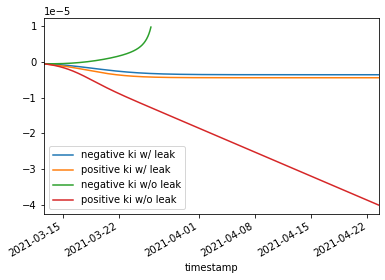

In [8]:
ldf[ldf.subset==0].plot(x='timestamp', y='price_adjustment_rate')
ax = plt.gca()
ldf[ldf.subset==1].plot(x='timestamp', y='price_adjustment_rate', ax=ax)
ldf[ldf.subset==2].plot(x='timestamp', y='price_adjustment_rate', ax=ax)
ldf[ldf.subset==3].plot(x='timestamp', y='price_adjustment_rate', ax=ax)
plt.legend(['negative ki w/ leak', 'positive ki w/ leak', 'negative ki w/o leak', 'positive ki w/o leak'])

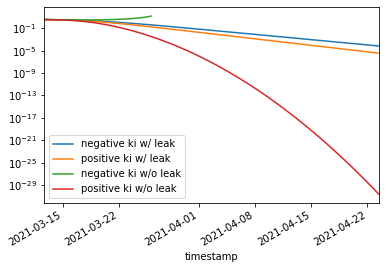

In [9]:
ldf[ldf.subset==0].plot(x='timestamp', y='target', logy=True)
ax = plt.gca()
ldf[ldf.subset==1].plot(x='timestamp', y='target', logy=True,ax=ax)
ldf[ldf.subset==2].plot(x='timestamp', y='target', logy=True, ax=ax)
ldf[ldf.subset==3].plot(x='timestamp', y='target', logy=True, ax=ax)
plt.legend(['negative ki w/ leak', 'positive ki w/ leak', 'negative ki w/o leak', 'positive ki w/o leak'])

After we run the simulation, certain post processing steps should be taken, as shown below:

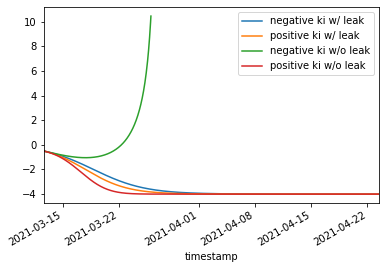

In [10]:
ldf[ldf.subset==0].plot(x='timestamp', y='error')
ax = plt.gca()
ldf[ldf.subset==1].plot(x='timestamp', y='error',ax=ax)
ldf[ldf.subset==2].plot(x='timestamp', y='error',  ax=ax)
ldf[ldf.subset==3].plot(x='timestamp', y='error', ax=ax)
plt.legend(['negative ki w/ leak', 'positive ki w/ leak', 'negative ki w/o leak', 'positive ki w/o leak'])

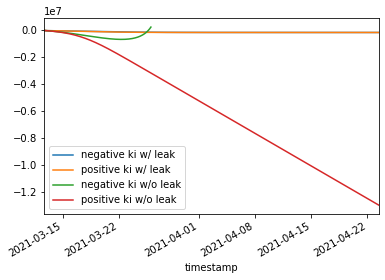

In [11]:
ldf[ldf.subset==0].plot(x='timestamp', y='integral')
ax = plt.gca()
ldf[ldf.subset==1].plot(x='timestamp', y='integral',ax=ax)
ldf[ldf.subset==2].plot(x='timestamp', y='integral',  ax=ax)
ldf[ldf.subset==3].plot(x='timestamp', y='integral', ax=ax)
plt.legend(['negative ki w/ leak', 'positive ki w/ leak', 'negative ki w/o leak', 'positive ki w/o leak'])

In [12]:
sdf = ldf[ldf.timestep <50].copy()

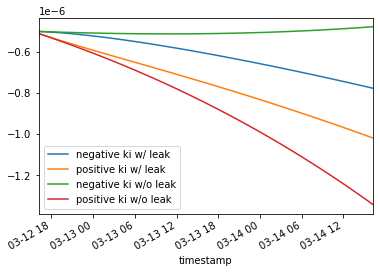

In [13]:
sdf[sdf.subset==0].plot(x='timestamp', y='price_adjustment_rate')
ax = plt.gca()
sdf[sdf.subset==1].plot(x='timestamp', y='price_adjustment_rate', ax=ax)
sdf[sdf.subset==2].plot(x='timestamp', y='price_adjustment_rate', ax=ax)
sdf[sdf.subset==3].plot(x='timestamp', y='price_adjustment_rate', ax=ax)
plt.legend(['negative ki w/ leak', 'positive ki w/ leak', 'negative ki w/o leak', 'positive ki w/o leak'])

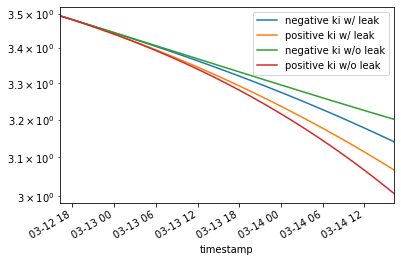

In [14]:
sdf[sdf.subset==0].plot(x='timestamp', y='target', logy=True)
ax = plt.gca()
sdf[sdf.subset==1].plot(x='timestamp', y='target', logy=True,ax=ax)
sdf[sdf.subset==2].plot(x='timestamp', y='target', logy=True, ax=ax)
sdf[sdf.subset==3].plot(x='timestamp', y='target', logy=True, ax=ax)
plt.legend(['negative ki w/ leak', 'positive ki w/ leak', 'negative ki w/o leak', 'positive ki w/o leak'])

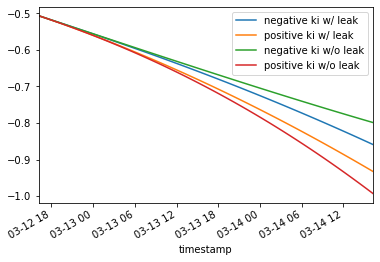

In [15]:
sdf[sdf.subset==0].plot(x='timestamp', y='error')
ax = plt.gca()
sdf[sdf.subset==1].plot(x='timestamp', y='error',ax=ax)
sdf[sdf.subset==2].plot(x='timestamp', y='error',  ax=ax)
sdf[sdf.subset==3].plot(x='timestamp', y='error', ax=ax)
plt.legend(['negative ki w/ leak', 'positive ki w/ leak', 'negative ki w/o leak', 'positive ki w/o leak'])

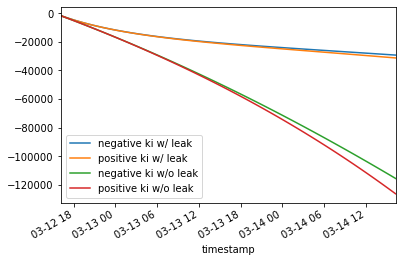

In [16]:
sdf[sdf.subset==0].plot(x='timestamp', y='integral')
ax = plt.gca()
sdf[sdf.subset==1].plot(x='timestamp', y='integral',ax=ax)
sdf[sdf.subset==2].plot(x='timestamp', y='integral',  ax=ax)
sdf[sdf.subset==3].plot(x='timestamp', y='integral', ax=ax)
plt.legend(['negative ki w/ leak', 'positive ki w/ leak', 'negative ki w/o leak', 'positive ki w/o leak'])

## Conclusion